In [198]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision
import numpy as np
import torchvision.transforms as T
import torch
from torch.utils.data import Dataset
import cv2
import os
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from albumentations.core.transforms_interface import ImageOnlyTransform

In [56]:
train_dataset_path = '../dataset/handwritten_math_symbols/train/'
eval_dataset_path = '../dataset/handwritten_math_symbols/eval/'

In [303]:
class Erosin(ImageOnlyTransform):
    def apply(self, img, **params):
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, tuple(np.random.randint(1, 4, 2)))
        img = cv2.erode(img, kernel, iterations=1)
        return img
    
class Dilation(ImageOnlyTransform):
    def apply(self, img, **params):
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, tuple(np.random.randint(1, 2, 2)))
        img = cv2.dilate(img, kernel, iterations=1)
        return img
    
class ToBlackAndWhite(ImageOnlyTransform):
    def apply(self, img, **params):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return img

In [329]:
model_input_shape = (32, 32)
train_dataset_transform = A.Compose([
    A.Resize(width=model_input_shape[0]+4, height=model_input_shape[0]+4),
    A.RandomCrop(model_input_shape[0], model_input_shape[0]),
    A.Perspective(scale=(0.05, 0.1),p=1, fit_output=True, pad_val=(255, 255, 255)),
    A.Rotate(limit=20, p=1),
    Dilation(p=0.5),
    Erosin(p=0.5),
    ToBlackAndWhite(p=1),
    ToTensorV2()
])

In [330]:
# A.ToGray?

In [331]:
train_dataset_org = torchvision.datasets.ImageFolder(root=train_dataset_path)
# eval_dataset = torchvision.datasets.ImageFolder(root=eval_dataset_path, transform=eval_dataset_transform)

In [332]:
class ImageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        paths = []
        class_to_idx = {}
        idx_to_class = {}
        for i, label in enumerate(os.listdir(root)):
            paths += [[root+label+'/'+p, label] for p in os.listdir(root+label)] 
            class_to_idx[label] = i+0
            idx_to_class[i+0] = label
        self.class_to_idx = class_to_idx
        self.idx_to_class = idx_to_class
        self.paths = paths
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image_filepath, label = self.paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, self.class_to_idx[label]
train_dataset = ImageDataset(root=train_dataset_path, transform=train_dataset_transform)

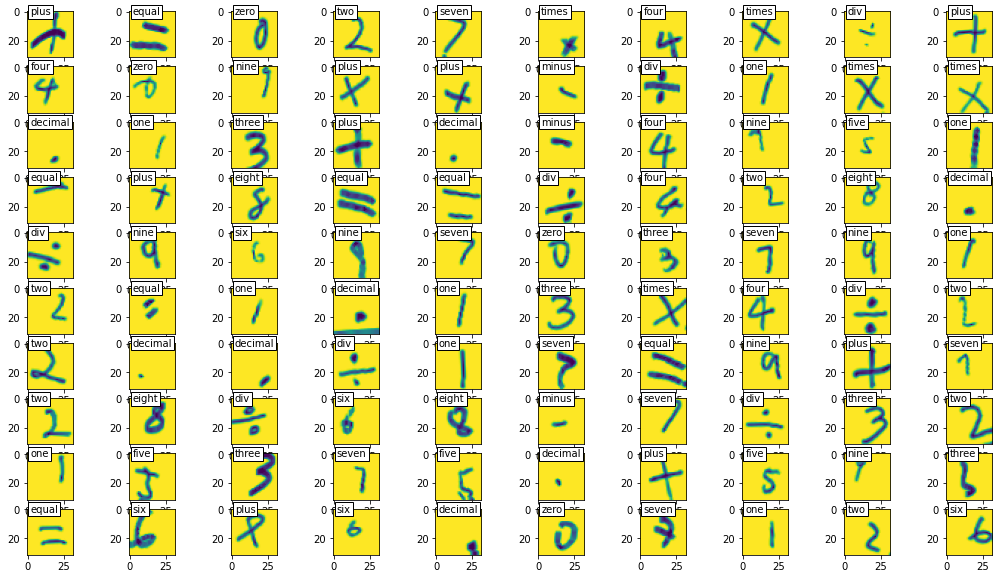

In [341]:
import math
plt.rcParams['figure.figsize'] = [18, 10]
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=100,  shuffle=True) 
    batch = next(iter(loader))
    images, labels = batch
    width = 10
    f, axarr = plt.subplots(math.ceil(len(labels)/width), width)
    row, col = 0, 0
    for i, image in enumerate(images):
        label = train_dataset.idx_to_class[int(labels[i])]
        axarr[row,col].imshow(np.transpose(image, (1, 2, 0)))
        axarr[row,col].text(2, 2, label , bbox={'facecolor': 'white', 'pad': 2})
        col+=1
        if(col%width == 0):
            row+=1
            col = 0
    plt.show()
show_transformed_images(train_dataset)